# Junk Food Binary Classification with KNN

This notebook implements a **K-Nearest Neighbors (KNN)** model for image classification from a **COCO JSON dataset**.

## Before you start

Make sure you have access to GPU. In case of any problems, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, click `Save` and try again.

In [1]:
!nvidia-smi

Sun Jan 18 08:43:22 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   64C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


In [3]:
!mkdir -p {HOME}/datasets
%cd {HOME}/datasets


/content/datasets


## Install packages using pip

In [4]:
!pip install roboflow==1.2.11 torch==2.9.0 torchvision==0.24.0 scikit-learn==1.6.1 tqdm==4.67.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 78.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


## Download dataset from Roboflow

Don't forget to change the `API_KEY` with your dataset key.

We replicate your original dataset setup. Even though the dataset is labeled for object detection, we’ll use the full image classification approach with KNN. Labels will be derived from the most frequent class per image.

In [5]:
from roboflow import Roboflow
from google.colab import userdata

rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace(userdata.get('ROBOFLOW_WORKSPACE_ID')).project(userdata.get('ROBOFLOW_PROJECT_ID'))
version = project.version(userdata.get('ROBOFLOW_DATASET_VERSION'))
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Junk-Food-Detection-10 in coco:: 100%|██████████| 5280/5280 [00:02<00:00, 2496.92it/s]


In [6]:
%cd {HOME}

/content


## Dataset Loading and Label Extraction

We will use a classification model. So, for labeling, we use two classes: junk-food-ad and non-junk-food-ad. Given the fact that the dataset is multiclass, the rule is: if there is at least one bounding box belonging to a particular image, it's junk-food-ad. Otherwise, it's non-junk-food-ad

In [7]:
import json
import os
from pathlib import Path
from typing import Dict, List, Tuple


def load_coco_annotations(json_path: str) -> Dict:
    with open(json_path, 'r') as f:
        return json.load(f)


def process_dataset_part(
    part_dir: str,
    positive_class: str,
    negative_class: str,
    annotations_filename: str = "_annotations.coco.json"
) -> Tuple[List[str], List[str]]:
    annotations_path = os.path.join(part_dir, annotations_filename)

    if not os.path.exists(annotations_path):
        raise FileNotFoundError(f"Annotations file not found: {annotations_path}")

    # Load annotations
    coco_data = load_coco_annotations(annotations_path)

    # Create a mapping of image_id to whether it has annotations
    images_with_boxes = set()
    for annotation in coco_data['annotations']:
        images_with_boxes.add(annotation['image_id'])

    # Process images in order
    image_paths = []
    labels = []

    for image_info in coco_data['images']:
        image_id = image_info['id']
        file_name = image_info['file_name']

        image_path = os.path.join(part_dir, file_name)
        image_paths.append(image_path)

        # Assign binary label based on presence of bounding boxes
        if image_id in images_with_boxes:
            labels.append(positive_class)
        else:
            labels.append(negative_class)

    return image_paths, labels


def process_full_dataset(
    dataset_root: str,
    positive_class: str = 'junk-food-ad',
    negative_class: str = 'non-junk-food-ad',
    parts: List[str] = ['train', 'valid', 'test']
) -> Tuple[Dict[str, List[str]], Dict[str, List[str]], List[str]]:
    # Define binary classes
    classes = [positive_class, negative_class]

    all_image_paths = {}
    all_labels = {}

    for part in parts:
        part_dir = os.path.join(dataset_root, part)

        if not os.path.exists(part_dir):
            print(f"Warning: Directory not found: {part_dir}. Skipping...")
            continue

        image_paths, labels = process_dataset_part(part_dir, positive_class, negative_class)

        all_image_paths[part] = image_paths
        all_labels[part] = labels

    return all_image_paths, all_labels, classes


image_paths_dict, labels_dict, classes = process_full_dataset(dataset.location)

print("\n" + "="*50)
print("DATASET SUMMARY")
print("="*50)
print(f"\nClasses: {classes}")
print(f"\nDataset parts processed:")

for part in image_paths_dict.keys():
    print(f"\n{part.upper()}:")
    print(f"  Total images: {len(image_paths_dict[part])}")
    print(f"  Total labels: {len(labels_dict[part])}")
    print(f"  Label distribution:")
    for cls in classes:
        count = labels_dict[part].count(cls)
        percentage = (count / len(labels_dict[part]) * 100) if labels_dict[part] else 0
        print(f"    - {cls}: {count} ({percentage:.1f}%)")


DATASET SUMMARY

Classes: ['junk-food-ad', 'non-junk-food-ad']

Dataset parts processed:

TRAIN:
  Total images: 4614
  Total labels: 4614
  Label distribution:
    - junk-food-ad: 2925 (63.4%)
    - non-junk-food-ad: 1689 (36.6%)

VALID:
  Total images: 440
  Total labels: 440
  Label distribution:
    - junk-food-ad: 277 (63.0%)
    - non-junk-food-ad: 163 (37.0%)

TEST:
  Total images: 218
  Total labels: 218
  Label distribution:
    - junk-food-ad: 131 (60.1%)
    - non-junk-food-ad: 87 (39.9%)


## Feature extraction of training set using pretrained models

KNN itself cannot extract visual features, it only compares numeric vectors.  
Therefore, we use **pretrained** models (without their classification heads) to extract image embeddings of train set.

These embeddings (feature vectors) represent each image in a high-dimensional space that captures visual similarity.  
The extracted features are stored as a NumPy matrix and later fed into the KNN classifier.

In [8]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm
import numpy as np

def extract_features(image_paths, model, feature_dim, transform, model_name):
    features = []
    with torch.no_grad():
        for path in tqdm(image_paths, desc=f"Extracting features - {model_name}"):
            try:
                img = Image.open(path).convert("RGB")
                tensor = transform(img).unsqueeze(0).to(device)
                feat = model(tensor).squeeze().cpu().numpy()
                features.append(feat)
            except Exception as e:
                print(f"Error with {path}: {e}")
                features.append(np.zeros(feature_dim))
    return np.array(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_configs = [
    {
        'name': 'ResNeXt-101',
        'loader': lambda: models.resnext101_32x8d(weights=models.ResNeXt101_32X8D_Weights.DEFAULT),
        'modifier': lambda m: torch.nn.Sequential(*list(m.children())[:-1]),
        'transform': models.ResNet50_Weights.DEFAULT.transforms(),
        'feature_dim': 2048
    },
    {
        'name': 'EfficientNet V2',
        'loader': lambda: models.efficientnet_v2_m(weights=models.EfficientNet_V2_M_Weights.DEFAULT),
        'modifier': lambda m: torch.nn.Sequential(*list(m.children())[:-1]),
        'transform': models.EfficientNet_V2_M_Weights.DEFAULT.transforms(),
        'feature_dim': 1280
    },
    {
        'name': 'ConvNeXt',
        'loader': lambda: models.convnext_base(weights=models.ConvNeXt_Base_Weights.DEFAULT),
        'modifier': lambda m: torch.nn.Sequential(*list(m.children())[:-1]),
        'transform': models.ConvNeXt_Base_Weights.DEFAULT.transforms(),
        'feature_dim': 1024
    },
    {
        'name': 'ViT',
        'loader': lambda: models.vit_b_16(weights=models.ViT_B_16_Weights.DEFAULT),
        'modifier': lambda m: (setattr(m.heads, 'head', torch.nn.Identity()), m)[1],
        'transform': models.ViT_B_16_Weights.DEFAULT.transforms(),
        'feature_dim': 768
    },
    {
        'name': 'Swin Transformer',
        'loader': lambda: models.swin_v2_b(weights=models.Swin_V2_B_Weights.DEFAULT),
        'modifier': lambda m: torch.nn.Sequential(*list(m.children())[:-1]),
        'transform': models.Swin_B_Weights.DEFAULT.transforms(),
        'feature_dim': 1024
    },
    {
        'name': 'DINOv2',
        'loader': lambda: torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14'),
        'modifier': lambda m: m,  # No modification needed
        'transform': transforms.Compose([
            transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'feature_dim': 768
    }
]

loaded_models = []
for config in model_configs:
    model = config['loader']()
    model = config['modifier'](model)
    model = model.to(device)
    model.eval()
    loaded_models.append({
        'model': model,
        'name': config['name'],
        'transform': config['transform'],
        'feature_dim': config['feature_dim']
    })

# Extract features for all models on train set
all_features = {}
for model_info in loaded_models:
    features = extract_features(
        image_paths_dict['train'],
        model_info['model'],
        model_info['feature_dim'],
        model_info['transform'],
        model_info['name']
    )
    all_features[model_info['name']] = features
    print(f"Feature matrix shape - {model_info['name']}: {features.shape}")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnext101_32x8d-110c445d.pth" to /root/.cache/torch/hub/checkpoints/resnext101_32x8d-110c445d.pth


100%|██████████| 340M/340M [00:01<00:00, 193MB/s]


Downloading: "https://download.pytorch.org/models/efficientnet_v2_m-dc08266a.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_m-dc08266a.pth


100%|██████████| 208M/208M [00:01<00:00, 187MB/s]


Downloading: "https://download.pytorch.org/models/convnext_base-6075fbad.pth" to /root/.cache/torch/hub/checkpoints/convnext_base-6075fbad.pth


100%|██████████| 338M/338M [00:02<00:00, 142MB/s]


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:01<00:00, 187MB/s]


Downloading: "https://download.pytorch.org/models/swin_v2_b-781e5279.pth" to /root/.cache/torch/hub/checkpoints/swin_v2_b-781e5279.pth


100%|██████████| 336M/336M [00:01<00:00, 183MB/s]


Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


xFormers is not available (SwiGLU)
xFormers is not available (Attention)
xFormers is not available (Block)


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:01<00:00, 344MB/s]
Extracting features - ResNeXt-101: 100%|██████████| 4614/4614 [02:19<00:00, 33.08it/s]


Feature matrix shape - ResNeXt-101: (4614, 2048)


Extracting features - EfficientNet V2: 100%|██████████| 4614/4614 [03:03<00:00, 25.12it/s]


Feature matrix shape - EfficientNet V2: (4614, 1280)


Extracting features - ConvNeXt: 100%|██████████| 4614/4614 [01:31<00:00, 50.42it/s]


Feature matrix shape - ConvNeXt: (4614, 1024)


Extracting features - ViT: 100%|██████████| 4614/4614 [01:23<00:00, 54.94it/s]


Feature matrix shape - ViT: (4614, 768)


Extracting features - Swin Transformer: 100%|██████████| 4614/4614 [03:28<00:00, 22.13it/s]


Feature matrix shape - Swin Transformer: (4614, 1024)


Extracting features - DINOv2: 100%|██████████| 4614/4614 [02:00<00:00, 38.27it/s]

Feature matrix shape - DINOv2: (4614, 768)


## "Training" the KNN Classifiers

KNN is "trained" (fitted actually) using a simple distance-based rule:
- Each image is classified based on the majority vote of its *k* nearest neighbors in the feature space.
- We use `k=5` neighbors for this experiment.

After training, we compute accuracy.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (confusion_matrix, accuracy_score, f1_score, precision_score, recall_score)

RESULTS_PATH = os.path.join(HOME, "runs", "classify")
os.makedirs(RESULTS_PATH, exist_ok=True)

encoder = LabelEncoder()
y_train = encoder.fit_transform(labels_dict['train'])

# Train KNN classifiers for all models
trained_models = {}
for model_name, features in all_features.items():
    knn = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
    knn.fit(features, y_train)

    trained_models[model_name] = knn
    print(f"Trained KNN for {model_name}")

Trained KNN for ResNeXt-101
Trained KNN for EfficientNet V2
Trained KNN for ConvNeXt
Trained KNN for ViT
Trained KNN for Swin Transformer
Trained KNN for DINOv2


## Metrics

In [10]:
def evaluate_model(X, y, split_name, knn, model_name):
    split_dir = os.path.join(RESULTS_PATH, split_name)
    os.makedirs(split_dir, exist_ok=True)
    y_pred = knn.predict(X)

    # We need pos_label=0 because the positive class is at 0.
    # Kinda weird, but that's how I implemented the dataset parsing and I realized the situation later on, sorry.
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, pos_label=0)
    recall = recall_score(y, y_pred, pos_label=0)
    f1 = f1_score(y, y_pred, pos_label=0)
    conf_matrix = confusion_matrix(y, y_pred)

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

## Metrics on validation set

In [11]:
# Extract features for validation set
all_valid_features = {}
for model_info in loaded_models:
    features = extract_features(
        image_paths_dict['valid'],
        model_info['model'],
        model_info['feature_dim'],
        model_info['transform'],
        model_info['name']
    )
    all_valid_features[model_info['name']] = features

y_valid = encoder.transform(labels_dict['valid'])

# Evaluate all models on valid set
for model_name, knn in trained_models.items():
  results = evaluate_model(all_valid_features[model_name], y_valid, "valid", knn, model_name)
  print(f"{model_name} - Valid Set:")
  print(f"  Accuracy:  {results['accuracy']:.4f}")
  print(f"  Precision: {results['precision']:.4f}")
  print(f"  Recall:    {results['recall']:.4f}")
  print(f"  F1 Score:  {results['f1_score']:.4f}")
  print(f"  Confusion Matrix:")
  print(f"  {results['confusion_matrix']}")

Extracting features - DINOv2: 100%|██████████| 440/440 [00:11<00:00, 38.64it/s]


ResNeXt-101 - Valid Set:
  Accuracy:  0.8977
  Precision: 0.8893
  Recall:    0.9567
  F1 Score:  0.9217
  Confusion Matrix:
  [[265  12]
 [ 33 130]]
EfficientNet V2 - Valid Set:
  Accuracy:  0.8864
  Precision: 0.8796
  Recall:    0.9495
  F1 Score:  0.9132
  Confusion Matrix:
  [[263  14]
 [ 36 127]]
ConvNeXt - Valid Set:
  Accuracy:  0.8864
  Precision: 0.9039
  Recall:    0.9170
  F1 Score:  0.9104
  Confusion Matrix:
  [[254  23]
 [ 27 136]]
ViT - Valid Set:
  Accuracy:  0.8955
  Precision: 0.8942
  Recall:    0.9458
  F1 Score:  0.9193
  Confusion Matrix:
  [[262  15]
 [ 31 132]]
Swin Transformer - Valid Set:
  Accuracy:  0.8932
  Precision: 0.9049
  Recall:    0.9278
  F1 Score:  0.9162
  Confusion Matrix:
  [[257  20]
 [ 27 136]]
DINOv2 - Valid Set:
  Accuracy:  0.9250
  Precision: 0.9296
  Recall:    0.9531
  F1 Score:  0.9412
  Confusion Matrix:
  [[264  13]
 [ 20 143]]


## Metrics on test set

Don't forget we are trying some models, so that's why we are listing multiple metrics.

Extracting features - DINOv2: 100%|██████████| 218/218 [00:05<00:00, 38.48it/s]



TEST SET METRICS - ResNeXt-101
Accuracy: 0.876
Precision: 0.856 (junk-food-ad)
Recall: 0.954 (junk-food-ad)
F1-Score: 0.903 (junk-food-ad)
Confusion Matrix:


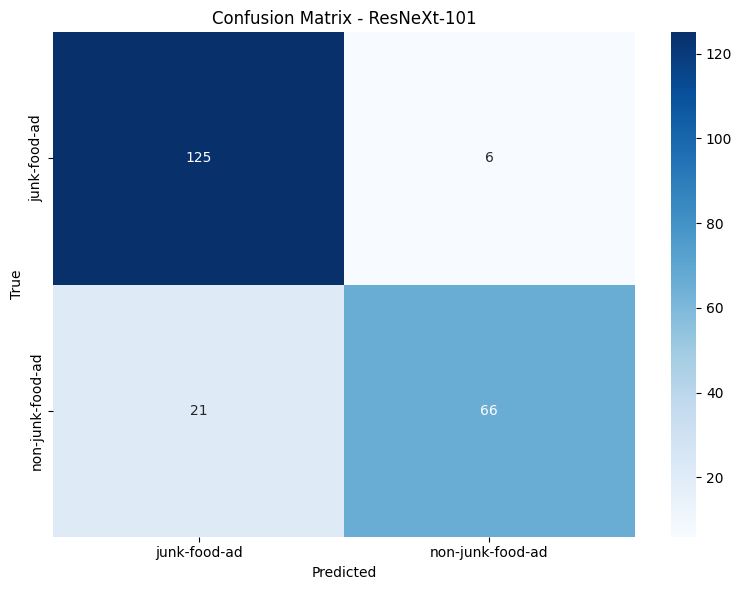


TEST SET METRICS - EfficientNet V2
Accuracy: 0.908
Precision: 0.899 (junk-food-ad)
Recall: 0.954 (junk-food-ad)
F1-Score: 0.926 (junk-food-ad)
Confusion Matrix:


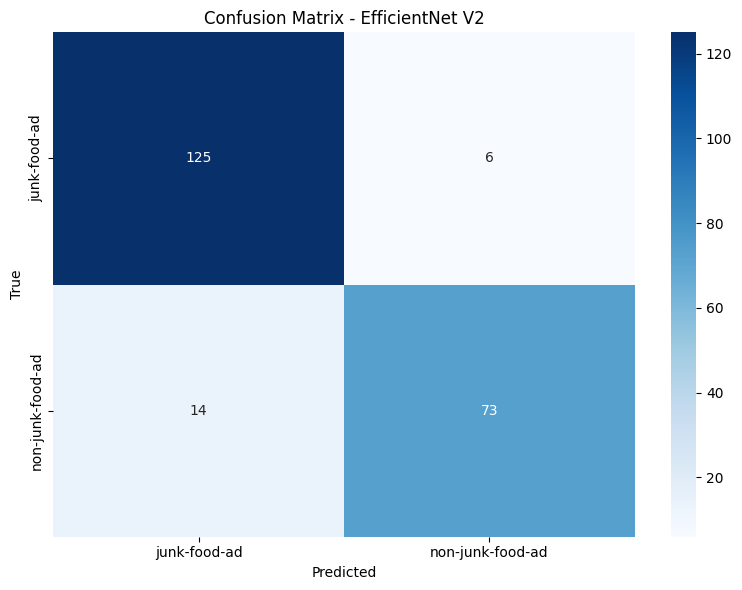


TEST SET METRICS - ConvNeXt
Accuracy: 0.876
Precision: 0.888 (junk-food-ad)
Recall: 0.908 (junk-food-ad)
F1-Score: 0.898 (junk-food-ad)
Confusion Matrix:


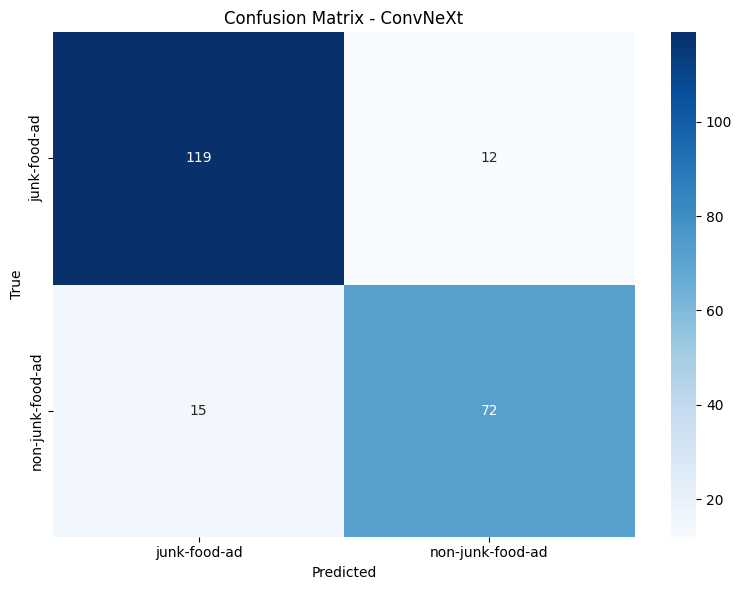


TEST SET METRICS - ViT
Accuracy: 0.890
Precision: 0.891 (junk-food-ad)
Recall: 0.931 (junk-food-ad)
F1-Score: 0.910 (junk-food-ad)
Confusion Matrix:


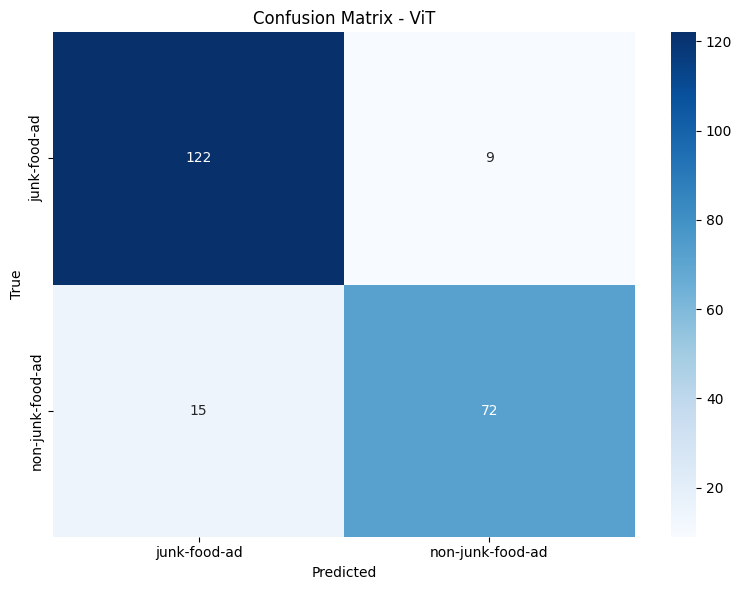


TEST SET METRICS - Swin Transformer
Accuracy: 0.881
Precision: 0.907 (junk-food-ad)
Recall: 0.893 (junk-food-ad)
F1-Score: 0.900 (junk-food-ad)
Confusion Matrix:


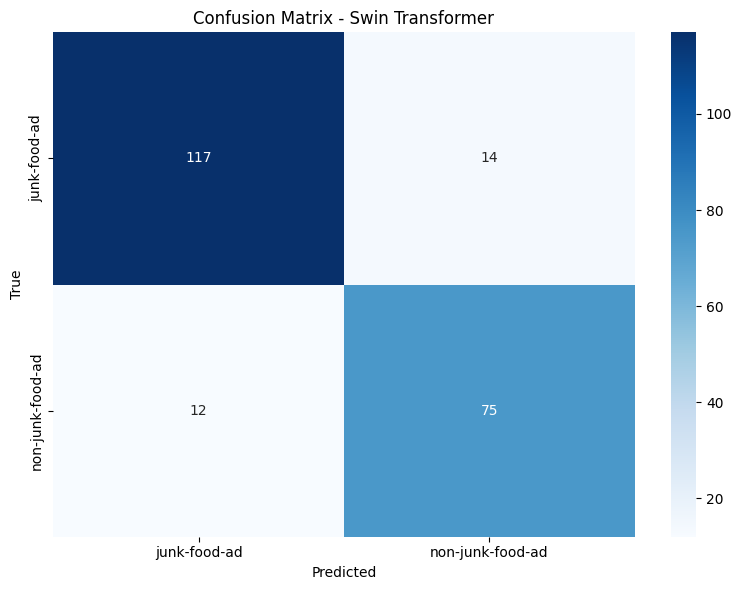


TEST SET METRICS - DINOv2
Accuracy: 0.913
Precision: 0.900 (junk-food-ad)
Recall: 0.962 (junk-food-ad)
F1-Score: 0.930 (junk-food-ad)
Confusion Matrix:


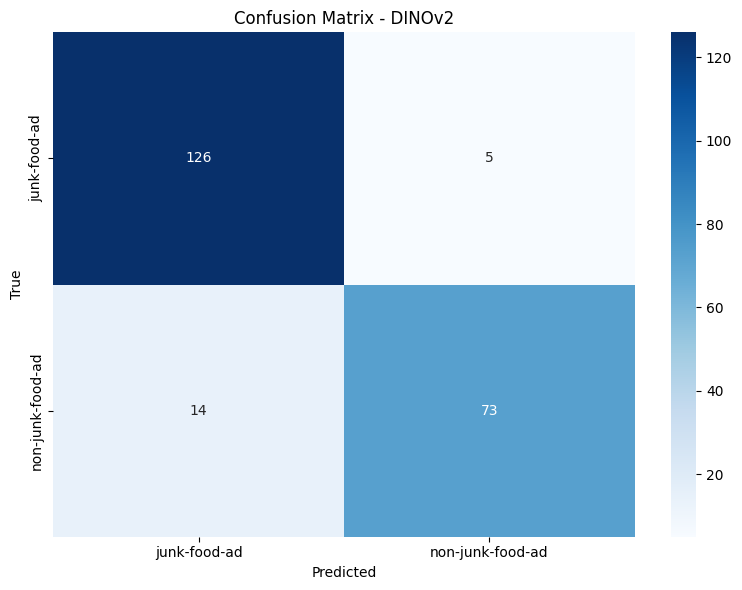

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

all_test_features = {}
for model_info in loaded_models:
    features = extract_features(
        image_paths_dict['test'],
        model_info['model'],
        model_info['feature_dim'],
        model_info['transform'],
        model_info['name']
    )
    all_test_features[model_info['name']] = features

y_test = encoder.transform(labels_dict['test'])

# Evaluate all models on test set
for model_name, knn in trained_models.items():
    results = evaluate_model(all_test_features[model_name], y_test, "test", knn, model_name)

    print("\n" + "="*50)
    print(f"TEST SET METRICS - {model_name}")
    print("="*50)
    print(f"Accuracy: {results['accuracy']:.3f}")
    print(f"Precision: {results['precision']:.3f} (junk-food-ad)")
    print(f"Recall: {results['recall']:.3f} (junk-food-ad)")
    print(f"F1-Score: {results['f1_score']:.3f} (junk-food-ad)")
    print("Confusion Matrix:")

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        results['confusion_matrix'],
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=['junk-food-ad', 'non-junk-food-ad'],
        yticklabels=['junk-food-ad', 'non-junk-food-ad']
    )
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.tight_layout()
    plt.show()

## Real images test

Let's test the best model (DINOv2) on random images from the test set.

In [13]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from PIL import Image as PILImage

# Use the best performing model (DINOv2)
best_model_name = "DINOv2"
best_knn = trained_models[best_model_name]

# Get the model info for DINOv2
dinov2_info = None
for model_info in loaded_models:
    if model_info['name'] == best_model_name:
        dinov2_info = model_info
        break

# Get indices of positive class images only (junk-food-ad)
# We only want to display interesting images that have actual junk food ads
positive_indices = [i for i, label in enumerate(labels_dict['test']) if label == 'junk-food-ad']

# Pick 5 random test images from positive class
test_indices = random.sample(positive_indices, min(5, len(positive_indices)))

# Define colors for labels
colors = {
    "junk-food-ad": "#FF6B6B",      # Red
    "non-junk-food-ad": "#4ECDC4"   # Teal
}
default_color = "#95A5A6"

for idx, random_idx in enumerate(test_indices, 1):
    random_image_path = image_paths_dict['test'][random_idx]
    true_label = labels_dict['test'][random_idx]

    print(f"{'='*60}")
    print(f"Image {idx}/5: {random_image_path}")
    print('='*60)

    # Load and preprocess the image
    image = PILImage.open(random_image_path).convert("RGB")
    image_tensor = dinov2_info['transform'](image).unsqueeze(0).to(device)

    # Extract features
    with torch.no_grad():
        features = dinov2_info['model'](image_tensor)
        features = features.cpu().numpy().flatten().reshape(1, -1)

    # Predict
    y_pred_encoded = best_knn.predict(features)[0]
    predicted_label = encoder.inverse_transform([y_pred_encoded])[0]

    # Get prediction probabilities
    proba = best_knn.predict_proba(features)[0]
    confidence = proba.max()
    is_correct = predicted_label == true_label

    # Display the image with prediction
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(image)
    ax.axis("off")

    # Create label badge
    label_color = colors.get(predicted_label, default_color)
    label_text = predicted_label.upper()

    # Add colored badge at the bottom
    badge = mpatches.FancyBboxPatch(
        (0.25, -0.08), 0.5, 0.06,
        boxstyle="round,pad=0.01",
        facecolor=label_color,
        edgecolor="white",
        linewidth=2,
        transform=ax.transAxes,
        clip_on=False
    )
    ax.add_patch(badge)
    ax.text(
        0.5, -0.05,
        label_text,
        transform=ax.transAxes,
        fontsize=12,
        fontweight="bold",
        color="white",
        ha="center",
        va="center"
    )

    plt.tight_layout()
    plt.show()

    print(f"Model: {best_model_name}")
    print(f"Prediction: {predicted_label} (confidence: {confidence:.2%})")
    print(f"True label: {true_label}")
    print(f"Correct: {is_correct}")
    print(f"Class probabilities:")
    for cls_idx, cls_proba in enumerate(proba):
        cls_name = encoder.inverse_transform([cls_idx])[0]
        print(f"  {cls_name}: {cls_proba:.2%}")


Output hidden; open in https://colab.research.google.com to view.